# Outline:
1. Exploratory data analysis
3. Modeling
4. Conclusion

## Exploratory data analysis
In this notebook, we will explore the data collected for the Indonesian sign language recognition project. Let's explore the datasets first and then we will move into the modeling stage. The datasets contains action videos recorded in MP4 format for different words.

In [55]:
# import all the packages
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd

In [56]:
# This file path contains all the preprocessed data ready for CNN-based models having fixed frames and resolutions.
data_path = "../data/data_processed_v1/"

# List the contents of the file path
!ls ../data/data_processed_v1/

adik     buruk    haus     kertas   maaf     minum    rumah    teman
anak     dengar   ibu      kucing   main     nama     sedikit  tidur
besar    gembira  jalan    lapar    makan    orang    selamat
buka     guru     keluarga lihat    marah    panggil  senyum


The names of the each folder corresponds to an Indonesian word and it contains the corresponding action videos. Let's check the contents of the "adik" folder.

In [58]:
!ls ../data/preprocessed/adik

1_normalized.mp4                kenji_normalized.mp4
Bhavitha_Bojja_normalized.mp4   kenzo_7_normalized.mp4
Monu_Babu_Baitha_normalized.mp4 louis_9_normalized.mp4
Roshan_Thapa_normalized.mp4     mahsa_normalized.mp4
Viorelia_normalized.mp4         vaishnavi_desai_normalized.mp4


The first folder contains the normalized version of the action videos recorded by multiple people and it contains 10 videos. These videos were recorded by multiple collaborators who are part of this Omdena challenge,

Let's take a look at the other folders as well.

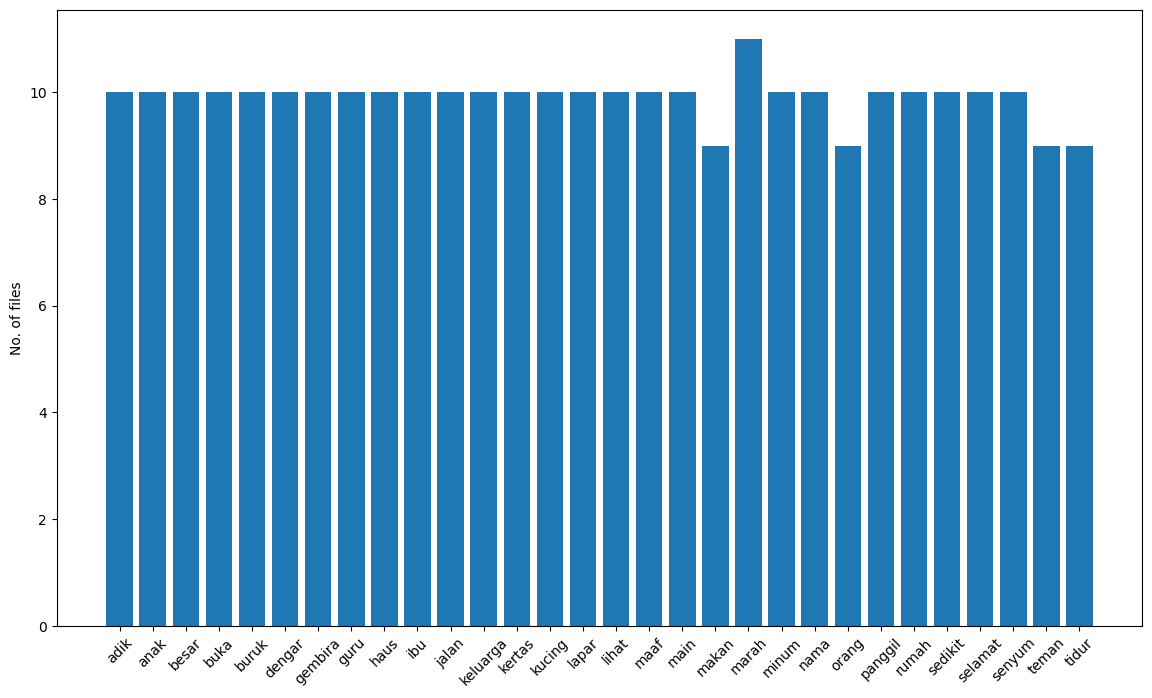

In [60]:
# Listing number of video files in each folder list
folds = os.listdir(data_path)
file_list = np.zeros(len(folds))

# Collecting the filepath of each video files and their associated folder labeling
# Will be used for train and test split of the data
video_filepath = []
labels = []

for i,fold in enumerate(sorted(folds)):
    files = glob.glob(data_path+fold+"/*.mp4")
    nfiles = len(files)
    file_list[i] = nfiles
    for filepath in files:
        video_filepath.append(filepath)
        labels.append(i)

# saving the information into a pandas dictionary
df = pd.DataFrame.from_dict({'X_path':video_filepath, 'Y':labels})
df = df.sample(frac=1) # shuffling the data

fig, ax = plt.subplots(figsize=(14,8))

ax.bar(sorted(folds), file_list)
ax.set_ylabel("No. of files")
ax.tick_params(axis='x', labelrotation = 45)
plt.show()
    

Here each of the xlabels represent an Indonesian word and the video files associated with that. 
Now let's take a look at the frame rates and resolution of videos in these folders.

In [62]:
filename = data_path+"/adik/1_normalized.mp4"
#ipd.Video(filename)

In [63]:
# Let's iterate through each folder and the files to collect some metadata
folds = os.listdir(data_path)

for fold in sorted(folds):
    files = glob.glob(data_path+fold+"/*.mp4")
    for file in files:
        # Load the video
        vid = cv2.VideoCapture(file)
        
        # Get the framerate
        fr = vid.get(cv2.CAP_PROP_FPS)

        # Total number of frames
        nframes = vid.get(cv2.CAP_PROP_FRAME_COUNT)

        # Duration
        dur = nframes/fr
        
        # Video height and width
        height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
        width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
        
        print(f"{fold}, {os.path.basename(file)}, Frame rate: {fr}, No. of Frames : {nframes}, Duration:{dur}s, Height {height}, Width {width}")

        # Unload the video
        vid.release()

adik, Viorelia_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, kenzo_7_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, Bhavitha_Bojja_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, Monu_Babu_Baitha_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, vaishnavi_desai_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, louis_9_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, mahsa_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, kenji_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 270.0
adik, 1_processed.mp4, Frame rate: 30.0, No. of Frames : 30.0, Duration:1.0s, Height 270.0, Width 2

These are preprocessed videos and all of them have the same number of frames, frame rate, duration and image dimensions.

120


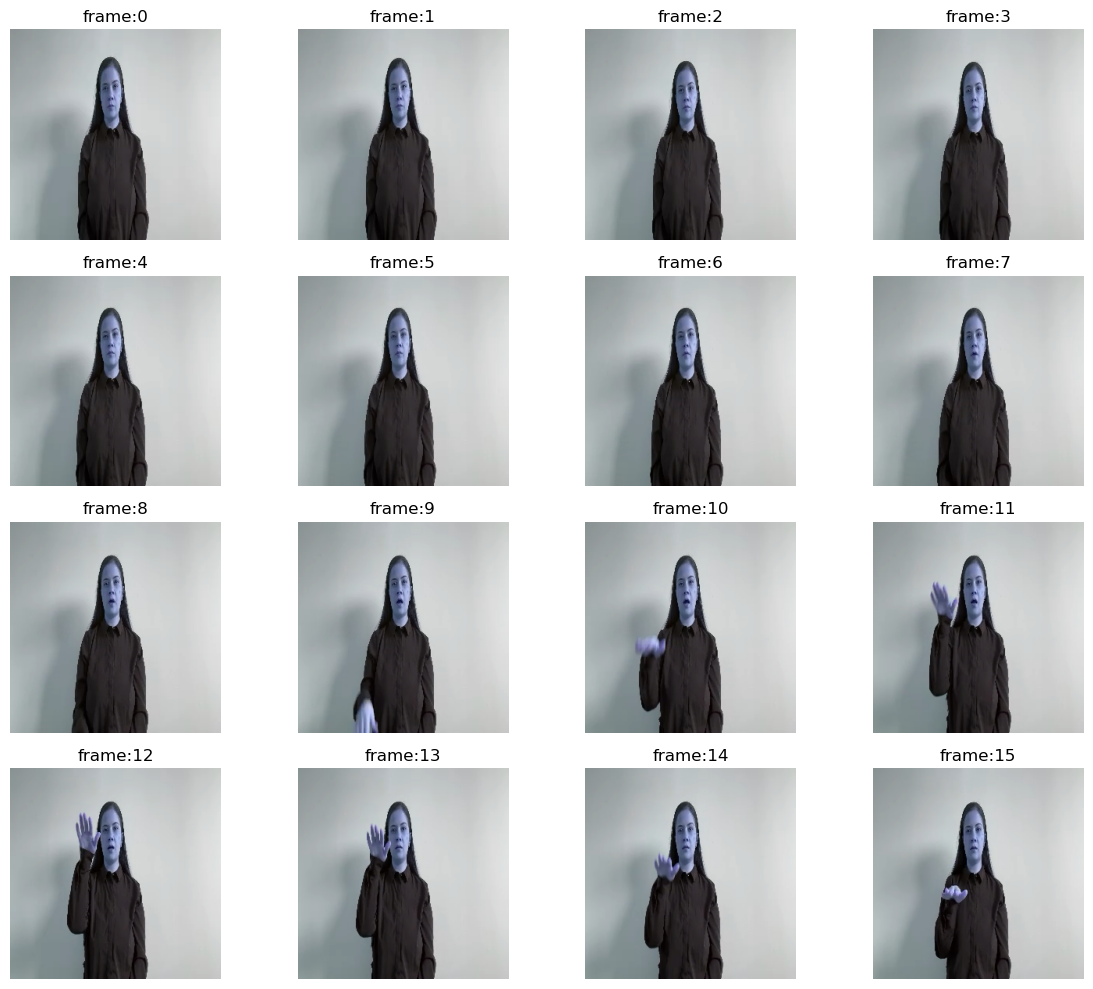

In [65]:
# Let's take a look at different frames in a single video from the first folder
images = []
for fold in sorted(folds)[:2]:
    files = glob.glob(data_path+fold+"/*.mp4")
    for file in files[:2]:
        # Load the video
        vid = cv2.VideoCapture(file)
        
        # Get the framerate
        fr = vid.get(cv2.CAP_PROP_FPS)

        # Total number of frames
        nframes = vid.get(cv2.CAP_PROP_FRAME_COUNT)

        while True:
            ret, img = vid.read()
            if ret == False:
                break
            else:
                images.append(img)

        # Unload the video
        vid.release()

print(len(images)) 

fig, axs = plt.subplots(4, 4, figsize=(12,10), tight_layout = True)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(images[i])
    axs[i].set_title(f"frame:{i}")
    axs[i].axis("off")
plt.show()

## Data Preprocessing
Here we will do a test-train split of the data first. We will try out the model first and then move on the data augmentation part. For that we need to collect the filepath of each video file and the associated labeling with it. There are in total 30 output classes which can be labelled from 0 to 29.

### Data Splitting


In [67]:
# data frame containing list of files and labels
df.head(10)

,X_path,Y
288,../data/data_processed_v1/tidur/Marouf_tidur_p...,29
292,../data/data_processed_v1/tidur/tidur_processe...,29
52,../data/data_processed_v1/dengar/Monu_Babu_Bai...,5
49,../data/data_processed_v1/buruk/kenzo_2_proces...,4
257,../data/data_processed_v1/sedikit/thant htoo s...,25
6,../data/data_processed_v1/adik/mahsa_processed...,0
177,../data/data_processed_v1/main/shikha_processe...,17
129,../data/data_processed_v1/kertas/nadya_process...,12
113,../data/data_processed_v1/keluarga/mahsa_proce...,11
295,../data/data_processed_v1/tidur/thant htoo san...,29


In [68]:
from sklearn.model_selection import train_test_split

# stratisfied splitting the data into 70% train and 30 % test to ensure that the test data contains 
# more or less equal distributions of different classes
X_train_path, X_test_path, Y_train, Y_test = train_test_split(df['X_path'], df['Y'], test_size=0.2, random_state=42, stratify = df['Y'])

# checking the number of samples in each category of the test data
Y_test.value_counts().sort_values()
#X_train_path.head(5)

Y
13    2
14    2
10    2
9     2
19    2
7     2
23    2
26    2
24    2
27    2
22    2
29    2
20    2
4     2
28    2
15    2
12    2
11    2
5     2
8     2
17    2
1     2
3     2
16    2
18    2
25    2
0     2
6     2
2     2
21    2
Name: count, dtype: int64

### Data extraction from the video files

In [70]:
def load_data(df):
    """
    Returns the array with loaded images from
    videos
    args:
    df : dataframe containing the filepaths
    """
    samp = df.shape[0]
    #print(samp)
    data = np.zeros((samp, 30, 270, 270, 3), dtype = np.float32) # Each video has 30 frames and each frame has 224 pixels height, width and 3 channels
    for i in range(samp):
        filename = df.iloc[i]
        
        # Load the video
        vid = cv2.VideoCapture(filename)
        
        # Total number of frames
        nframes = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

        for f in range(nframes):
            
            ret, img = vid.read()
            if ret == False:
                break
            else:
                data[i,f,:,:,:] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0

        # Unload the video
        vid.release()

    return data        

In [71]:
# Get the train data and test data

X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

print(f" X train shape : {X_train.shape}")
print(f"X test shape : {X_test.shape}")

 X train shape : (237, 30, 270, 270, 3)
X test shape : (60, 30, 270, 270, 3)


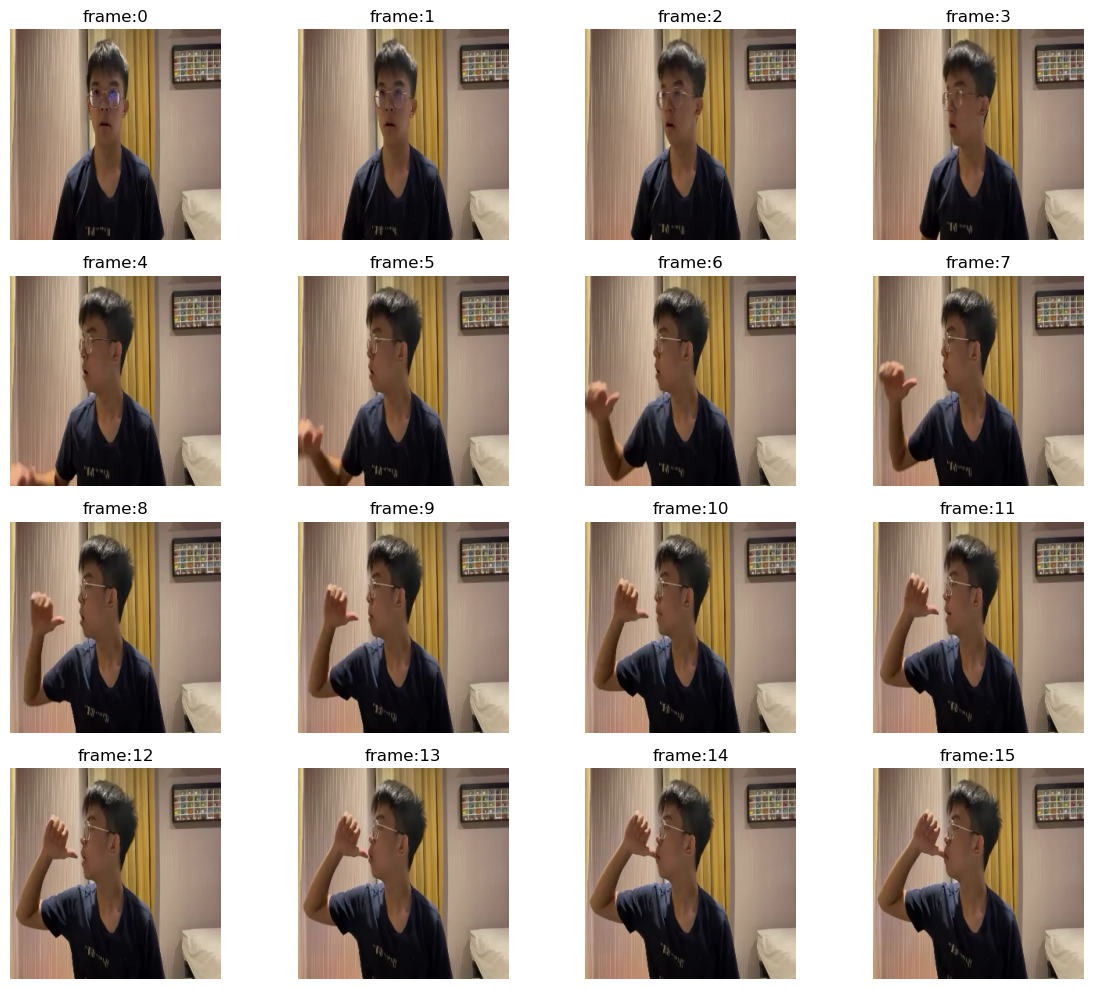

In [83]:
# Let's plot a random video file (eg: 30 th file) and check the data frames
fig, axs = plt.subplots(4, 4, figsize=(12,10), tight_layout = True)
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(X_train[30, i, :, :, :])
    axs[i].set_title(f"frame:{i}")
    axs[i].axis("off")
plt.show()

## Modeling of the data
We will start with a simple CNN-LSTM model and see how it performs. Depending on the metrics, we can carry out video augmentation and other models. Let's build the model using keras and tensorflow.

In the case of a CNN-LSTM model, the CNN will extract the features from each frame of the image and they are fed to the LSTM model for modeling the temporal variations in the video. The **TimeDistributed** wrapper in Keras can be used to apply the same convolutionsl operations to different time frames and combine the results after that. Let's build the model now.

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input, TimeDistributed, LSTM, GlobalAveragePooling2D

def create_CNN_LSTM(input_shape, nclass):

    """
    Function returns the model output
    Args:
    input shape: shape of the input train/test data (excluding the batch size)
    nclass: number of output classes
    """
    model = Sequential()

    # CNN part
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu', padding='valid', name = 'conv1')))
    model.add(TimeDistributed(MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool1')))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu', padding='valid', name = 'conv2')))
    model.add(TimeDistributed(MaxPool2D(pool_size=(2, 2), strides=(2,2), name = 'pool2')))
    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=3, strides=(2,2), activation='relu', padding='valid', name = 'conv3')))
    model.add(TimeDistributed(MaxPool2D(pool_size=(4, 4), strides=(4,4), name = 'pool3')))

    # flattening
    model.add(TimeDistributed(Flatten()))
              
    # LSTM part
    model.add(LSTM(64))
              
    # Drop out regularization
    model.add(Dropout(0.2))
              
    # fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Final output layer, softmax regression
    model.add(Dense(nclass, activation='softmax'))

    return model

In [87]:
nclass = len(np.unique(Y_train))
input_shape = X_train.shape[1:] 

print(f"Number of classes : {nclass}")

Number of classes : 30


In [91]:
# Creating the model
cnn_lstm = create_CNN_LSTM(input_shape, nclass)

# Model summary
cnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 30, 134, 134, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 67, 67, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 33, 33, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 16, 16, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 30, 7, 7, 128)   

In [97]:
import tensorflow as tf

def keras_model_memory_usage_in_bytes(model, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

print(keras_model_memory_usage_in_bytes(cnn_lstm, 32)/1e+9)

3.113862302


In [95]:
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [99]:
# compile and train the model
cnn_lstm.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# If the y labels are intigers use sparse categorical entropy loss function, if y labels are one hot encoded then utilize the categorical
# cross entropy

# let's set the test data as the validation data as of now since we have limited data for training.
hist_cnn_lstm = cnn_lstm.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data = (X_test, Y_test))

Epoch 1/10
8/8 [==============================] - 52s 6s/step - loss: 3.4096 - accuracy: 0.0211 - val_loss: 3.4036 - val_accuracy: 0.0333
Epoch 2/10
8/8 [==============================] - 47s 6s/step - loss: 3.4042 - accuracy: 0.0380 - val_loss: 3.4032 - val_accuracy: 0.0333
Epoch 3/10
8/8 [==============================] - 48s 6s/step - loss: 3.4045 - accuracy: 0.0211 - val_loss: 3.4026 - val_accuracy: 0.0333
Epoch 4/10
8/8 [==============================] - 51s 6s/step - loss: 3.4026 - accuracy: 0.0338 - val_loss: 3.4021 - val_accuracy: 0.0333
Epoch 5/10
8/8 [==============================] - 50s 6s/step - loss: 3.4015 - accuracy: 0.0253 - val_loss: 3.4021 - val_accuracy: 0.0500
Epoch 6/10
8/8 [==============================] - 51s 6s/step - loss: 3.3998 - accuracy: 0.0464 - val_loss: 3.4026 - val_accuracy: 0.0333
Epoch 7/10
8/8 [==============================] - 51s 6s/step - loss: 3.4020 - accuracy: 0.0169 - val_loss: 3.4040 - val_accuracy: 0.0333
Epoch 8/10
8/8 [==================

/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_50718/3660938882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/var/folders/c8/g5hp4hlx7dv6gv7n9zdg74rc0000gn/T/ipykernel_50718/3660938882.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

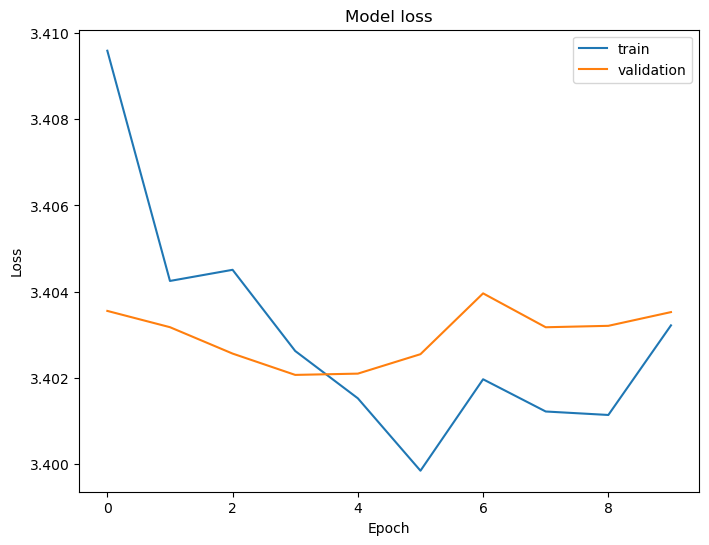

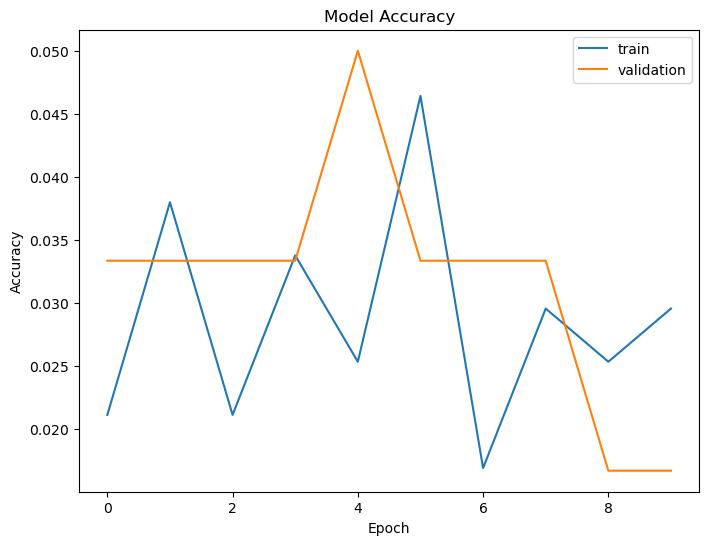

In [101]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(hist_cnn_lstm.history)

# losses data frame
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)

# accuracy data frame
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)

# plotting the loss and accuracy
df_loss.plot(title='Model loss',figsize=(8,6)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(8,6)).set(xlabel='Epoch',ylabel='Accuracy')

In [105]:
del cnn_lstm

### ResNet-LSTM Model
Since the basic model is not doing a good job in learing from the data. Let's replace the CNN with a ResNet model. The Resnet model is very good in detecting complicated patters from the images.

In [107]:
from tensorflow.keras.applications import ResNet50

def call_resnet(input_shape):
    
    # Calling the Resnet model
    res_model = ResNet50(
    include_top=False, # remove the top layer or the classification layer.
    weights="imagenet", # utilize imagenet weights
    input_tensor=None,
    input_shape=input_shape[1:], # time steps axis not needed here
    pooling=None)  # no pooling mentioned

    #print a summary of the base model
    #res_model.summary()

    nb_layers = len(res_model.layers)
    print(f"No. of Resnet model layers: {nb_layers}")

    # Freeze the base model as we wan to use the pretrained weights
    res_model.trainable = False

    return res_model

def create_ResNet_LSTM(input_shape, nclass):

    """
    Function returns the model output
    Args:
    input shape: shape of the input train/test data (excluding the batch size)
    nclass: number of output classes
    """
    # start the model
    model = Sequential()

    # defining the input layer
    model.add(Input(shape=input_shape))

    # resnet layer for feature extraction
    model.add(TimeDistributed(call_resnet(input_shape))) # calling the resnet function here

    # adding a 2D global average to reduce the size and summarize the info in each channel
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    # flattening  not needed anymore with the global averaging
    #model.add(TimeDistributed(Flatten()))
              
    # LSTM part
    model.add(LSTM(64))
              
    # Drop out regularization
    model.add(Dropout(0.2))
              
    # fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Final output layer, softmax regression
    model.add(Dense(nclass, activation='softmax'))

    return model

In [109]:
# Create the model
res_lstm = create_ResNet_LSTM(input_shape, nclass)

No. of Resnet model layers: 175


In [111]:
#Summary of the model
res_lstm.summary()

print(f" Size of the Model in GB : {keras_model_memory_usage_in_bytes(res_lstm, 32)/1e+9}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 9, 9, 2048)   23587712  
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 2048)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 64)                540928    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)               

In [115]:
# compile and train the model
res_lstm.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# If the y labels are intigers use sparse categorical entropy loss function, if y labels are one hot encoded then utilize the categorical
# cross entropy

#with tf.device('/GPU:0'): # For gpu training, unfortunately tf-metal sucks bigtime

# let's set the test data as the validation data as of now since we have limited data for training.
hist_res_lstm = res_lstm.fit(X_train, Y_train, epochs=10, batch_size=4, validation_data = (X_test, Y_test))

Epoch 1/10
60/60 [==============================] - 621s 10s/step - loss: 3.4412 - accuracy: 0.0253 - val_loss: 3.4059 - val_accuracy: 0.0333
Epoch 2/10
60/60 [==============================] - 623s 10s/step - loss: 3.4210 - accuracy: 0.0127 - val_loss: 3.4048 - val_accuracy: 0.0333
Epoch 3/10
60/60 [==============================] - 614s 10s/step - loss: 3.4152 - accuracy: 0.0253 - val_loss: 3.4019 - val_accuracy: 0.0333
Epoch 4/10
60/60 [==============================] - 630s 11s/step - loss: 3.4104 - accuracy: 0.0253 - val_loss: 3.4018 - val_accuracy: 0.0333
Epoch 5/10
60/60 [==============================] - 632s 11s/step - loss: 3.4139 - accuracy: 0.0211 - val_loss: 3.4018 - val_accuracy: 0.0667
Epoch 6/10
20/60 [=========>....................] - ETA: 5:32 - loss: 3.4030 - accuracy: 0.0375

KeyboardInterrupt: 

## Conclusion

The simple CNN-LSTM model is not learning well as we can see from the training history. The issues causing this needs to be figured out.